In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from corset.data import Dataset
from corset.utils import flatten, makedir
from corset.samplers.discrim import CFTPDiscriminativitySampler
from corset.samplers.boley_discrim import BoleyCFTPDiscriminativitySampler
from corset.rule import Rule


In [3]:
from viz_utils import set_mpl_style
    
set_mpl_style()    

In [4]:
from typing import List, Tuple, Set


class SingleRuleEvaluator:
    def __init__(self, ds: Dataset):
        self._ds = ds
        self.Y_csc = self._ds.trn_Y.tocsc()
        self.X_csc = self._ds.trn_X.tocsc()
        
    def evaluate_rule(self, head: Set[int], tail: Set[int]):
        rule = Rule(head, tail)
        rule.bind_dataset(self.X_csc, self.Y_csc)
        perf = {
            'precision': rule.precision(), 
            'recall': rule.recall(),
            'KL_times_coverage': rule.marginal_coverage([]) * rule.KL(),
            'head_length': len(rule.head)
        }
        return perf

    def evaluate_rule_batch(self, rules: List[Tuple[Set[int]]]):
        return [self.evaluate_rule(*rule) for rule in rules]

In [5]:
from corset.samplers.uncovered_area import UncoveredAreaSampler
from corset.evaluation import TailEvaluator
from corset.utils import conjunctive_collapse_v2

In [6]:
def get_top_tails_by_area(ds, num_tails):
    tail_sampler = UncoveredAreaSampler(min_proba=0.5, random_state=1234, do_prune_edges=True)
    tail_sampler.fit(ds.trn_Y)

    te = TailEvaluator(ds)
    area_arr = te.area(tail_sampler._sample_space)
    tail_idx = np.argsort(area_arr)[::-1][:num_tails]
    return [tail_sampler._sample_space[idx] for idx in tail_idx]



In [7]:
def run_experiment_for_dataset(
    dataset_name, min_proba,
    num_samples_per_label=100,
    label_sample_size=50  # number of labels to sample
):
    ds = Dataset(name=dataset_name, datadir='../data')
    ds.load()
    X, Y = ds.trn_X, ds.trn_Y    

    Y_csc = Y.tocsc()
    
    sampler_ours = CFTPDiscriminativitySampler(proposal_distribution='tight', min_proba=min_proba)
    sampler_ours.build_sample_space_and_generate_rows(X)
    sampler_boley = BoleyCFTPDiscriminativitySampler()

    samplers = {
        'ours': sampler_ours,
        'boley': sampler_boley
    }    

    label_samples = np.random.permutation(Y.shape[1])[:label_sample_size]
    
    tail_sampels = get_top_tails_by_area(ds, label_sample_size)
    
    ev = SingleRuleEvaluator(ds)
    rows = []
    for tail in tqdm(tail_sampels):
        y = conjunctive_collapse_v2(Y_csc, tail)

        if len(np.unique(y)) < 2:
            # continue only one class, skip
            continue
        
        for name, sampler in samplers.items():
            sampler.fit(X, y)
            sampled_heads = sampler.sample(
                k=num_samples_per_label
            )

            rules = [(head, tail) for head in sampled_heads]

            records = ev.evaluate_rule_batch(rules)        

            for rec in records:
                rec['tail'] = tuple(tail)
                rec['dataset'] = dataset_name
                rec['sampler'] = name
            rows += records

    df = pd.DataFrame.from_records(rows)
    df['f1'] = 2 * df['precision'] * df['recall'] / (df['precision'] +  df['recall'])
    
    return df

In [9]:
exp_configs = [
    ('mediamill', 0.8),    
    ('Yelp', 0.8),
    ('corel5k', .8),        
    ('CAL500', 0.8),
    ('bibtex', 0.95),
    ('enron', 1.0),
    ('medical', .95),
    ('birds', 0.95),
    ('emotions', 0.5),
]
df_list = []
for dataset_name, min_proba in exp_configs:
    print(f'experimenting with dataset {dataset_name}')
    df = run_experiment_for_dataset(dataset_name, min_proba)
    df_list.append(df)


experimenting with dataset mediamill


[D 230115 22:40:38 pc:129] confidence graph construction: done
[D 230115 22:40:38 pc:131] converting to connectivity graph: done
[D 230115 22:40:38 pc:106] prune edges from the graph: done
[D 230115 22:40:38 pc:107] number of nodes: 120
[D 230115 22:40:38 pc:108] number of edges change: 6211 -> 815
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 11289.68it/s]
[D 230115 22:40:38 pc:120] running dfs takes: 0.03143906593322754
[D 230115 22:40:38 pc:122] sample space size: 3363
[D 230115 22:40:38 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.029794931411743164


[D 230115 22:40:45 PRETTI_invertedIndex:7] done
[I 230115 22:40:48 assignment:72] sample assignment done
[D 230115 22:40:48 pc:129] confidence graph construction: done
[D 230115 22:40:48 pc:131] converting to connectivity graph: done
[D 230115 22:40:48 pc:106] prune edges from the graph: done
[D 230115 22:40:48 pc:107] number of nodes: 101
[D 230115 22:40:48 pc:108] number of edges change: 2118 -> 380
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 120794.04it/s]
[D 230115 22:40:48 pc:120] running dfs takes: 0.004900217056274414
[D 230115 22:40:48 pc:122] sample space size: 893
[D 230115 22:40:48 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.004842042922973633


[D 230115 22:40:54 PRETTI_invertedIndex:7] done
[I 230115 22:40:55 assignment:72] sample assignment done
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 34/50 [01:24<00:35,  2.22s/it][W 230115 22:42:21 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=2147483648
[W 230115 22:42:21 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=2147483648
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:01<00:00,  2.43s/it]


experimenting with dataset Yelp


[D 230115 22:43:09 pc:129] confidence graph construction: done
[D 230115 22:43:12 pc:131] converting to connectivity graph: done
[D 230115 22:43:12 pc:106] prune edges from the graph: done
[D 230115 22:43:12 pc:107] number of nodes: 671
[D 230115 22:43:12 pc:108] number of edges change: 204976 -> 103
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 671/671 [00:00<00:00, 1091267.15it/s]
[D 230115 22:43:13 pc:120] running dfs takes: 0.005013942718505859
[D 230115 22:43:13 pc:122] sample space size: 778
[D 230115 22:43:13 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.0048100948333740234


[D 230115 22:43:22 PRETTI_invertedIndex:7] done
[I 230115 22:43:22 assignment:72] sample assignment done
[D 230115 22:43:22 pc:129] confidence graph construction: done
[D 230115 22:43:22 pc:131] converting to connectivity graph: done
[D 230115 22:43:22 pc:106] prune edges from the graph: done
[D 230115 22:43:22 pc:107] number of nodes: 5
[D 230115 22:43:22 pc:108] number of edges change: 10 -> 6
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27813.69it/s]
[D 230115 22:43:22 pc:120] running dfs takes: 0.0030698776245117188
[D 230115 22:43:22 pc:122] sample space size: 11
[D 230115 22:43:22 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:43:22 PRETTI_invertedIndex:7] done
[I 230115 22:43:22 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.0029990673065185547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


experimenting with dataset corel5k


[D 230115 22:43:35 pc:129] confidence graph construction: done
[D 230115 22:43:36 pc:131] converting to connectivity graph: done
[D 230115 22:43:36 pc:106] prune edges from the graph: done
[D 230115 22:43:36 pc:107] number of nodes: 499
[D 230115 22:43:36 pc:108] number of edges change: 49631 -> 0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1425720.50it/s]
[D 230115 22:43:36 pc:120] running dfs takes: 0.003599882125854492
[D 230115 22:43:36 pc:122] sample space size: 499
[D 230115 22:43:36 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.003537893295288086


[D 230115 22:43:38 PRETTI_invertedIndex:7] done
[I 230115 22:43:38 assignment:72] sample assignment done
[D 230115 22:43:38 pc:129] confidence graph construction: done
[D 230115 22:43:38 pc:131] converting to connectivity graph: done
[D 230115 22:43:38 pc:106] prune edges from the graph: done
[D 230115 22:43:38 pc:107] number of nodes: 374
[D 230115 22:43:38 pc:108] number of edges change: 3536 -> 527
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:00<00:00, 678490.35it/s]
[D 230115 22:43:38 pc:120] running dfs takes: 0.0052032470703125
[D 230115 22:43:38 pc:122] sample space size: 977
[D 230115 22:43:38 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.0051310062408447266


[D 230115 22:43:40 PRETTI_invertedIndex:7] done
[I 230115 22:43:40 assignment:72] sample assignment done
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]


experimenting with dataset CAL500


[D 230115 22:43:50 pc:129] confidence graph construction: done
[D 230115 22:43:50 pc:131] converting to connectivity graph: done
[D 230115 22:43:50 pc:106] prune edges from the graph: done
[D 230115 22:43:50 pc:107] number of nodes: 68
[D 230115 22:43:50 pc:108] number of edges change: 2210 -> 23
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 183771.05it/s]
[D 230115 22:43:50 pc:120] running dfs takes: 0.0029990673065185547
[D 230115 22:43:50 pc:122] sample space size: 91
[D 230115 22:43:50 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:43:50 PRETTI_invertedIndex:7] done
[I 230115 22:43:50 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.0029480457305908203


[D 230115 22:43:50 pc:129] confidence graph construction: done
[D 230115 22:43:50 pc:131] converting to connectivity graph: done
[D 230115 22:43:50 pc:106] prune edges from the graph: done
[D 230115 22:43:50 pc:107] number of nodes: 174
[D 230115 22:43:50 pc:108] number of edges change: 10427 -> 3426
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 3155.77it/s]
[D 230115 22:43:50 pc:120] running dfs takes: 0.0737309455871582
[D 230115 22:43:50 pc:122] sample space size: 11459
[D 230115 22:43:50 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:43:50 PRETTI_invertedIndex:7] done


elapsed in dfs_v2_aux: 0.07354116439819336


[I 230115 22:43:51 assignment:72] sample assignment done
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.12it/s]


experimenting with dataset bibtex


[D 230115 22:44:42 pc:129] confidence graph construction: done
[D 230115 22:44:59 pc:131] converting to connectivity graph: done
[D 230115 22:45:01 pc:106] prune edges from the graph: done
[D 230115 22:45:01 pc:107] number of nodes: 1836
[D 230115 22:45:01 pc:108] number of edges change: 1320369 -> 9790
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1836/1836 [00:00<00:00, 8452.48it/s]
[D 230115 22:45:01 pc:120] running dfs takes: 0.25756311416625977


elapsed in dfs_v2_aux: 0.25669312477111816


[D 230115 22:45:01 pc:122] sample space size: 48292
[D 230115 22:45:01 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:45:24 PRETTI_invertedIndex:7] done
[I 230115 22:45:31 assignment:72] sample assignment done
[D 230115 22:45:31 pc:129] confidence graph construction: done
[D 230115 22:45:31 pc:131] converting to connectivity graph: done
[D 230115 22:45:31 pc:106] prune edges from the graph: done
[D 230115 22:45:31 pc:107] number of nodes: 159
[D 230115 22:45:31 pc:108] number of edges change: 3506 -> 117
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 889192.45it/s]
[D 230115 22:45:31 pc:120] running dfs takes: 0.0035490989685058594
[D 230115 22:45:31 pc:122] sample space size: 286
[D 230115 22:45:31 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.003492116928100586


[D 230115 22:45:34 PRETTI_invertedIndex:7] done
[I 230115 22:45:34 assignment:72] sample assignment done
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.38it/s]


experimenting with dataset enron


[D 230115 22:46:26 pc:129] confidence graph construction: done
[D 230115 22:46:33 pc:131] converting to connectivity graph: done
[D 230115 22:46:33 pc:106] prune edges from the graph: done
[D 230115 22:46:33 pc:107] number of nodes: 1001
[D 230115 22:46:33 pc:108] number of edges change: 499511 -> 3071
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 86381.74it/s]
[D 230115 22:46:34 pc:120] running dfs takes: 0.031392812728881836
[D 230115 22:46:34 pc:122] sample space size: 5152
[D 230115 22:46:34 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.03119492530822754


[D 230115 22:46:35 PRETTI_invertedIndex:7] done
[I 230115 22:46:35 assignment:72] sample assignment done
[D 230115 22:46:35 pc:129] confidence graph construction: done
[D 230115 22:46:35 pc:131] converting to connectivity graph: done
[D 230115 22:46:35 pc:106] prune edges from the graph: done
[D 230115 22:46:35 pc:107] number of nodes: 53
[D 230115 22:46:35 pc:108] number of edges change: 576 -> 111
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 131849.41it/s]
[D 230115 22:46:35 pc:120] running dfs takes: 0.004446268081665039
[D 230115 22:46:35 pc:122] sample space size: 182
[D 230115 22:46:35 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:46:35 PRETTI_invertedIndex:7] done
[I 230115 22:46:35 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.004354000091552734


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 21/50 [00:19<00:24,  1.20it/s][W 230115 22:46:55 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=0
[W 230115 22:46:55 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=0
/Users/hanxiao1/code/corset/notebooks/../corset/samplers/boley_cftp.py:122: RuntimeWarning: overflow encountered in double_scalars
  ratio = (W_C * W_D_bar) / (W_C_bar * W_D)
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 35/50 [00:30<00:10,  1.45it/s][W 230115 22:47:06 boley_cftp:1

experimenting with dataset medical


[D 230115 22:47:15 pc:129] confidence graph construction: done
[D 230115 22:47:16 pc:131] converting to connectivity graph: done
[D 230115 22:47:17 pc:106] prune edges from the graph: done
[D 230115 22:47:17 pc:107] number of nodes: 1909
[D 230115 22:47:17 pc:108] number of edges change: 81935 -> 18629
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1909/1909 [00:00<00:00, 6058.95it/s]
[D 230115 22:47:17 pc:120] running dfs takes: 0.38764214515686035


elapsed in dfs_v2_aux: 0.38333606719970703


[D 230115 22:47:17 pc:122] sample space size: 297683
[D 230115 22:47:17 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:47:21 PRETTI_invertedIndex:7] done
[I 230115 22:47:44 assignment:72] sample assignment done
[D 230115 22:47:44 pc:129] confidence graph construction: done
[D 230115 22:47:44 pc:131] converting to connectivity graph: done
[D 230115 22:47:44 pc:106] prune edges from the graph: done
[D 230115 22:47:44 pc:107] number of nodes: 45
[D 230115 22:47:44 pc:108] number of edges change: 63 -> 23
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 262144.00it/s]
[D 230115 22:47:44 pc:120] running dfs takes: 0.003101348876953125
[D 230115 22:47:44 pc:122] sample space size: 69
[D 230115 22:47:44 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:47:4

elapsed in dfs_v2_aux: 0.0030050277709960938


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 44/50 [00:09<00:00,  6.52it/s][W 230115 22:47:54 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=32
[W 230115 22:47:54 boley_cftp:115] W_C is close to 0. Possibly encountering overflow. 
     |D^+ / D^-|=0 and |D^+ \cap D^-|=32
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


experimenting with dataset birds


[D 230115 22:47:55 pc:129] confidence graph construction: done
[D 230115 22:47:56 pc:131] converting to connectivity graph: done
[D 230115 22:47:56 pc:106] prune edges from the graph: done
[D 230115 22:47:56 pc:107] number of nodes: 271
[D 230115 22:47:56 pc:108] number of edges change: 24485 -> 1473
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 5087.67it/s]
[D 230115 22:47:56 pc:120] running dfs takes: 0.06147480010986328
[D 230115 22:47:56 pc:122] sample space size: 15298
[D 230115 22:47:56 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:47:56 PRETTI_invertedIndex:7] done


elapsed in dfs_v2_aux: 0.06130409240722656


[I 230115 22:47:56 assignment:72] sample assignment done
[D 230115 22:47:56 pc:129] confidence graph construction: done
[D 230115 22:47:56 pc:131] converting to connectivity graph: done
[D 230115 22:47:56 pc:106] prune edges from the graph: done
[D 230115 22:47:56 pc:107] number of nodes: 19
[D 230115 22:47:56 pc:108] number of edges change: 85 -> 9
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179082.64it/s]
[D 230115 22:47:56 pc:120] running dfs takes: 0.002843141555786133
[D 230115 22:47:56 pc:122] sample space size: 28
[D 230115 22:47:56 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:47:56 PRETTI_invertedIndex:7] done
[I 230115 22:47:56 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.0028018951416015625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  5.86it/s]
[D 230115 22:48:01 pc:129] confidence graph construction: done
[D 230115 22:48:01 pc:131] converting to connectivity graph: done
[D 230115 22:48:01 pc:106] prune edges from the graph: done
[D 230115 22:48:01 pc:107] number of nodes: 72
[D 230115 22:48:01 pc:108] number of edges change: 2286 -> 319


experimenting with dataset emotions


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 72419.64it/s]
[D 230115 22:48:01 pc:120] running dfs takes: 0.005440950393676758
[D 230115 22:48:01 pc:122] sample space size: 497
[D 230115 22:48:01 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:48:01 PRETTI_invertedIndex:7] done


elapsed in dfs_v2_aux: 0.005377769470214844


[I 230115 22:48:01 assignment:72] sample assignment done
[D 230115 22:48:01 pc:129] confidence graph construction: done
[D 230115 22:48:01 pc:131] converting to connectivity graph: done
[D 230115 22:48:01 pc:106] prune edges from the graph: done
[D 230115 22:48:01 pc:107] number of nodes: 6
[D 230115 22:48:01 pc:108] number of edges change: 14 -> 6
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67468.70it/s]
[D 230115 22:48:01 pc:120] running dfs takes: 0.002878904342651367
[D 230115 22:48:01 pc:122] sample space size: 13
[D 230115 22:48:01 PRETTI_invertedIndex:11] building inverted index...
[D 230115 22:48:01 PRETTI_invertedIndex:7] done
[I 230115 22:48:01 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.0028238296508789062


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.78it/s]


In [10]:
df = pd.concat(df_list, ignore_index=True)

# relative performance difference (use this one)

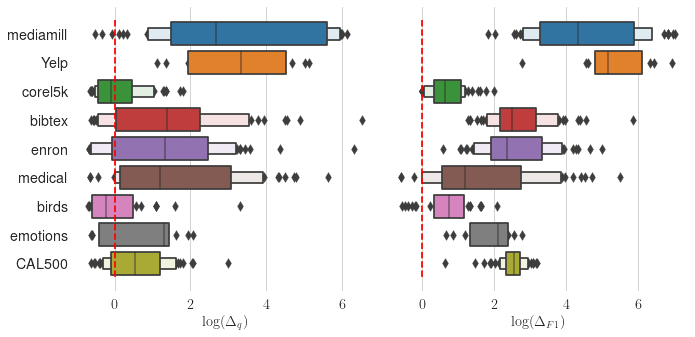

In [11]:
def get_relative_difference_by_feild(df_, field_name):
    boley_score = df_[df_['sampler'] == 'boley'][field_name].iloc[0]
    ours_score = df_[df_['sampler'] == 'ours'][field_name].iloc[0]
    
    return (ours_score - boley_score) / ours_score

def get_scaled_relative_difference_by_feild(df_, field_name):
    """apply to log1p transformation to the relative difference"""
    boley_score = df_[df_['sampler'] == 'boley'][field_name].iloc[0]
    ours_score = df_[df_['sampler'] == 'ours'][field_name].iloc[0]
    
    diff_abs = np.abs(ours_score - boley_score)
    diff_sign = np.sign(ours_score - boley_score)
    
    return diff_sign * np.log1p(diff_abs / boley_score) 



rel_diff_dfs = []
fields = ('KL_times_coverage', 'f1')
for field in fields:
    s = df.groupby(['dataset', 'tail', 'sampler'])[field].agg('max')    
    rel_diff_by_field = s.reset_index().groupby(['dataset', 'tail']).apply(
        lambda df_:  get_scaled_relative_difference_by_feild(df_, field)
    )
    rel_diff_dfs.append(rel_diff_by_field.to_frame(name='value').assign(metric=field).reset_index())
    

rel_diff_df = pd.concat(rel_diff_dfs, ignore_index=True)

# rename the metric name
sampler_name_mapping = {'KL_times_coverage': r"$\log(\Delta_q)$",
                        'f1': r'$\log(\Delta_{F1})$'}
rel_diff_df = rel_diff_df.assign(**{
    'metric-renamed': rel_diff_df['metric'].apply(lambda v: sampler_name_mapping[v])
})

# we use the ordering of datasets presented in the paper
order = ['mediamill', 'Yelp', 'corel5k', 'bibtex', 'enron', 'medical', 'birds', 'emotions', 'CAL500']
plot = sns.catplot(
    data=rel_diff_df, x='value', y='dataset', kind='boxen', col='metric-renamed', sharex=False,
    order=order
)

fig = plot.figure
for ax in fig.axes:
    title = ax.title.get_text()
    ax.set_title('')
    xlabel = title.split('=')[1].strip()
    ax.set_xlabel(xlabel)

    ax.vlines(0, -.5, 8.5, colors='r', linestyles='dashed')
fig.axes[0].set_ylabel('')

# fig.axes[0].set_title(r'$\Delta_q(ours; Boley\'s)$')
plot.figure.savefig('../plots/head-sampler-comparison-rel-diff.pdf')
